In [ ]:
## add id to original label guided dataset

import json
from tqdm import tqdm
from pathlib import Path

file_a_path = "/Users/phoebeeeee/ongoing/Beyond-noise/VariErr-Label-Guided-longest.json"
file_b_path = "/Users/phoebeeeee/ongoing/Beyond-noise/dataset/varierr.json"
output_path = "/Users/phoebeeeee/ongoing/Beyond-noise/VariErr-Label-Guided-longest-with-ID.json"

with open(file_b_path, "r") as f:
    full_dataset = [json.loads(line) for line in f]
    pair_to_id = {
        (sample["context"].strip(), sample["statement"].strip()): sample["id"]
        for sample in full_dataset
    }

print(f"Loaded {len(pair_to_id)} (context, statement) pairs from full dataset.")

with open(file_a_path, "r") as f:
    data = [json.loads(line) for line in f]

with open(output_path, "w") as f_out:
    for sample in tqdm(data):
        premise = sample["premise"].strip()
        hypothesis = sample["hypothesis"].strip()
        key = (premise, hypothesis)

        if key in pair_to_id:
            sample["id"] = pair_to_id[key]
        else:
            print(f"[Warning] Not found: premise='{premise[:50]}...', hypothesis='{hypothesis[:50]}...'")
            sample["id"] = None

        f_out.write(json.dumps(sample, ensure_ascii=False) + "\n")

print(f"✅ Done. Output saved to {output_path}")


Loaded 500 (context, statement) pairs from full dataset.


100%|██████████| 341/341 [00:00<00:00, 65680.46it/s]

✅ Done. Output saved to /Users/phoebeeeee/ongoing/Beyond-noise/VariErr-Label-Guided-longest-with-ID.json


In [7]:
# integrate explanations generated by LLMs to a singel file

import json, re
from pathlib import Path
from tqdm import tqdm

explanation_root = Path(
    "/Users/phoebeeeee/ongoing/Beyond-noise/2_llm_validation/500/LLM_exp+LLM_dist+LLM_validate/gpt-4.1/gpt_4.1_generation_raw"
)
input_jsonl = Path(
    "/Users/phoebeeeee/ongoing/Beyond-noise/dataset/varierr.json"
)
output_jsonl = Path("/Users/phoebeeeee/ongoing/Beyond-noise/2_llm_validation/500/LLM_exp+LLM_dist+LLM_validate/gpt-4.1/gpt_4.1_explanation_raw.jsonl")

# suffix = ".txt"

def clean_explanation(text: str) -> str:

    return re.sub(
        r"^\s*(?:[\d]+[\.\)]|[-•*]|[a-zA-Z][\.\)]|\(\w+\))\s+",
        "",
        text,
    ).strip()

label_map = {"E": "e", "N": "n", "C": "c"}

with open(input_jsonl, "r", encoding="utf-8") as f:
    instances = [json.loads(line) for line in f]

with open(output_jsonl, "w", encoding="utf-8") as fout:
    for instance in tqdm(instances, desc="Inject explanations"):
        sample_id = str(instance["id"])
        subfolder = explanation_root / sample_id
        new_comments = []

        if not subfolder.exists():
            print(f"missing folder: {subfolder}")
        else:
            for label in ["E", "N", "C"]:
                tried_files = [
                    f"{label}_third.txt"
                    # f"{label}_second.txt",
                    # f"{label}_first.txt",
                    # label,
                ]
        
                file_found = False
                for fname in tried_files:
                    file_path = subfolder / f"{fname}"
                    if file_path.exists():
                        with open(file_path, "r", encoding="utf-8") as f:
                            explanations = [
                                clean_explanation(line)
                                for line in f
                                if line.strip()
                            ]
                        new_comments.extend([[exp, label_map[label]] for exp in explanations])
                        file_found = True
                        break

                if not file_found:
                    print(f"⚠️ No file found for {label} in {subfolder}")
        new_instance = {
            "id": instance["id"],
            "premise": instance["context"],
            "hypothesis": instance["statement"],
            "generated_explanations": new_comments
        }

        fout.write(json.dumps(new_instance, ensure_ascii=False) + "\n")

print(f"✅ Done. New JSONL saved to: {output_jsonl.resolve()}")


Inject explanations: 100%|██████████| 500/500 [00:00<00:00, 931.68it/s]

✅ Done. New JSONL saved to: /Users/phoebeeeee/ongoing/Beyond-noise/2_llm_validation/500/LLM_exp+LLM_dist+LLM_validate/gpt-4.1/gpt_4.1_explanation_raw.jsonl


In [64]:
import json
import re

# 修改为你的文件路径
input_path = "/Users/phoebeeeee/ongoing/Beyond-noise/2_llm_validation/500/LLM_exp+LLM_dist+LLM_validate/gpt-4.1/manual_check_after_generation/scores.json"
output_path = "/Users/phoebeeeee/ongoing/Beyond-noise/2_llm_validation/500/LLM_exp+LLM_dist+LLM_validate/gpt-4.1/manual_check_after_generation/scores.json"  # 可与输入相同以覆盖

# 读取原始 JSON
with open(input_path, "r", encoding="utf-8") as f:
    data = json.load(f)

# 提取 value 中的数字
cleaned_data = {
    key: float(re.search(r"[\d.]+", value).group())
    for key, value in data.items()
}

# 保存为新 JSON 文件
with open(output_path, "w", encoding="utf-8") as f:
    json.dump(cleaned_data, f, ensure_ascii=False, indent=2)

print(f"✅ 清洗完成，已保存到 {output_path}")


✅ 清洗完成，已保存到 /Users/phoebeeeee/ongoing/Beyond-noise/2_llm_validation/500/LLM_exp+LLM_dist+LLM_validate/gpt-4.1/manual_check_after_generation/scores.json


Average: 0.9175


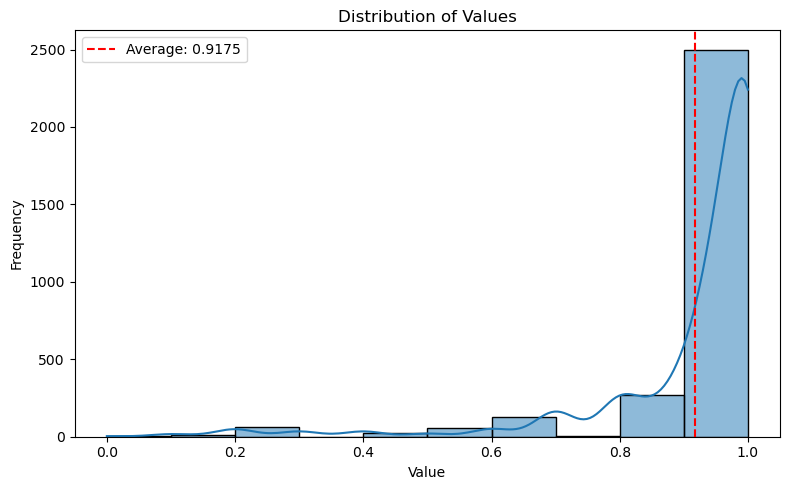

In [65]:
# average and distribution of scores
import json
import matplotlib.pyplot as plt
import seaborn as sns

with open('/Users/phoebeeeee/ongoing/Beyond-noise/2_llm_validation/500/LLM_exp+LLM_dist+LLM_validate/gpt-4.1/manual_check_after_generation/scores.json', 'r', encoding='utf-8') as f:
    data = json.load(f)

values = list(data.values())

average = sum(values) / len(values)
print(f"Average: {average:.4f}")

plt.figure(figsize=(8, 5))
sns.histplot(values, bins=10, kde=True)

plt.axvline(average, color='red', linestyle='--', label=f'Average: {average:.4f}')
plt.title('Distribution of Values')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.legend()
plt.tight_layout()
plt.show()


In [66]:
# filtering scores below 0.5 from a JSON file

import json

input_file = "/Users/phoebeeeee/ongoing/Beyond-noise/2_llm_validation/500/LLM_exp+LLM_dist+LLM_validate/gpt-4.1/manual_check_after_generation/scores.json"

with open(input_file, "r") as f:
    data = json.load(f)

filtered = {k: float(v) for k, v in data.items() if float(v) < 0.5}

print("Filtered results (value < 0.5):")
for k, v in filtered.items():
    print(f"{k}: {v}")

with open("/Users/phoebeeeee/ongoing/Beyond-noise/2_llm_validation/500/LLM_exp+LLM_dist+LLM_validate/gpt-4.1/manual_check_after_generation/scores_below_0.5.json", "w") as f:
    json.dump(filtered, f, indent=2)


Filtered results (value < 0.5):
1735n_e-0: 0.2
1735n_e-1: 0.2
76219n_c-5: 0.1
65066n_e-0: 0.2
76020e_c-3: 0.2
76020e_c-4: 0.1
48223n_c-5: 0.2
48223n_c-6: 0.3
48223n_c-7: 0.4
69815n_e-0: 0.4
69815n_e-1: 0.1
127290n_e-0: 0.3
127290n_e-1: 0.3
100792c_e-0: 0.1
100792c_e-1: 0.1
100792c_e-2: 0.2
75572n_c-4: 0.3
40486n_c-7: 0.1
145495c_e-1: 0.4
131261n_c-6: 0.2
131261n_c-7: 0.4
136360e_c-5: 0.3
102817c_e-0: 0.3
102817c_e-1: 0.2
102817c_e-2: 0.3
102817c_e-3: 0.4
124590c_c-3: 0.2
96583n_e-0: 0.1
103364n_c-5: 0.4
53866e_c-7: 0.3
132019n_n-4: 0.2
52542n_e-1: 0.3
88605e_c-4: 0.15
88605e_c-5: 0.2
81356e_e-1: 0.3
34176n_e-0: 0.3
76947n_e-1: 0.3
74768e_c-5: 0.3
122928e_c-4: 0.2
139409e_c-4: 0.2
139409e_c-5: 0.2
80630e_c-8: 0.3
98739n_c-8: 0.1
108624c_c-3: 0.2
108624c_c-4: 0.3
37407n_c-5: 0.3
37407n_c-6: 0.2
100768n_c-5: 0.3
100768n_c-6: 0.2
74509n_c-5: 0.2
7856c_e-0: 0.4
12562n_n-4: 0.2
124839c_e-0: 0.2
130680e_c-5: 0.2
130680e_c-6: 0.4
29844c_c-5: 0.3
56124n_e-0: 0.2
129081n_e-1: 0.2
45306n_e-2: 0.2

In [102]:
# add validation tag to explanations based on scores

import json
from tqdm import tqdm

score_file = "/Users/phoebeeeee/ongoing/Beyond-noise/2_llm_validation/500/LLM_exp+LLM_dist+LLM_validate/llama-8b/manual_check/scores.json" 
data_file = "/Users/phoebeeeee/ongoing/Beyond-noise/2_llm_validation/500/LLM_exp+LLM_dist+LLM_validate/llama-8b/llama_3.1_explanation_raw.jsonl"  
output_file = "/Users/phoebeeeee/ongoing/Beyond-noise/2_llm_validation/500/LLM_exp+LLM_dist+LLM_validate/llama-8b/manual_check/lama-8b_explanation_with_validation.jsonl"

with open(score_file, "r") as f:
    score_data = json.load(f)

score_data = {k: float(v) for k, v in score_data.items()}


with open(data_file, "r") as f:
    all_data = [json.loads(line) for line in f]

for instance in tqdm(all_data):
    inst_id = instance["id"]
    new_comments = []
    for idx, (reason_text, label_code) in enumerate(instance["generated_explanations"]):
        reason_id = f"{inst_id}_{label_code}-{idx}"
        if reason_id in score_data and score_data[reason_id] > 0.5:
            tag = "validated"
        elif reason_id in score_data and score_data[reason_id] <= 0.5:
            tag = "not_validated"
        else:
            print("missing:", reason_id)

        new_comments.append([reason_text, label_code, tag])
    instance["generated_explanations"] = new_comments

with open(output_file, "w") as f:
    for instance in all_data:
        f.write(json.dumps(instance, ensure_ascii=False) + "\n")

print(f"✅ Done. Output saved to: {output_file}")


100%|██████████| 500/500 [00:00<00:00, 79766.92it/s]

✅ Done. Output saved to: /Users/phoebeeeee/ongoing/Beyond-noise/2_llm_validation/500/LLM_exp+LLM_dist+LLM_validate/llama-8b/manual_check/lama-8b_explanation_with_validation.jsonl


In [103]:
# add label-level counts

import json
from collections import defaultdict
from tqdm import tqdm

input_file = "/Users/phoebeeeee/ongoing/Beyond-noise/2_llm_validation/500/LLM_exp+LLM_dist+LLM_validate/llama-8b/manual_check/lama-8b_explanation_with_validation.jsonl"
output_file = "/Users/phoebeeeee/ongoing/Beyond-noise/2_llm_validation/500/LLM_exp+LLM_dist+LLM_validate/llama-8b/manual_check/lama-8b_explanation_with_validation_count.jsonl"

with open(input_file, "r") as f:
    all_data = [json.loads(line) for line in f]

for instance in tqdm(all_data):
    comments = instance.get("generated_explanations", [])

    count_r1 = defaultdict(int)
    count_r2 = defaultdict(int)

    for reason_text, label_code, tag in comments:
        count_r1[label_code] += 1  
        if tag == "validated":
            count_r2[label_code] += 1 

    set_r1 = set(count_r1.keys())
    set_r2 = set(count_r2.keys())

    instance["label_count_round_1"] = dict(count_r1)
    instance["label_set_round_1"] = list(set_r1)

    instance["label_count_round_2"] = dict(count_r2)
    instance["label_set_round_2"] = list(set_r2)

 
    instance["error"] = list(set_r1 - set_r2)
    not_validated_exp = {
        label: count_r1[label] - count_r2.get(label, 0)
        for label in count_r1
        if count_r1[label] - count_r2.get(label, 0) > 0
    }
    instance["not_validated_exp"] = not_validated_exp

with open(output_file, "w") as f:
    for instance in all_data:
        f.write(json.dumps(instance, ensure_ascii=False) + "\n")

print(f"✅ Done. Output saved to: {output_file}")

100%|██████████| 500/500 [00:00<00:00, 108863.79it/s]

✅ Done. Output saved to: /Users/phoebeeeee/ongoing/Beyond-noise/2_llm_validation/500/LLM_exp+LLM_dist+LLM_validate/llama-8b/manual_check/lama-8b_explanation_with_validation_count.jsonl


In [104]:
# error comparison between LLM validation and VariErr dataset

import json
import csv
from tqdm import tqdm

file_a_path = "/Users/phoebeeeee/ongoing/Beyond-noise/2_llm_validation/500/LLM_exp+LLM_dist+LLM_validate/llama-8b/manual_check/lama-8b_explanation_with_validation_count.jsonl"
file_b_path = "/Users/phoebeeeee/ongoing/Beyond-noise/dataset/varierr.json"
output_csv_path = "/Users/phoebeeeee/ongoing/Beyond-noise/2_llm_validation/500/LLM_exp+LLM_dist+LLM_validate/llama-8b/manual_check/merged_errors.csv"

with open(file_a_path, "r") as f:
    data_a = {json.loads(line)["id"]: json.loads(line) for line in f}

with open(file_b_path, "r") as f:
    data_b = {json.loads(line)["id"]: json.loads(line) for line in f}

all_ids = list(data_a.keys())

with open(output_csv_path, "w", newline="") as f:
    writer = csv.DictWriter(f, fieldnames=["id", "llm_not_calidated_error", "varierr_error"])
    writer.writeheader()

    for id_ in tqdm(all_ids):
        if id_ not in data_b:
            print(f"ID {id_} not found in VariErr dataset.")
        
        row = {
            "id": id_,
            "llm_not_calidated_error": json.dumps(data_a.get(id_, {}).get("error", []), ensure_ascii=False),
            "varierr_error": json.dumps(data_b.get(id_, {}).get("error_labels", []), ensure_ascii=False)
        }
        writer.writerow(row)

print(f"CSV saved to：{output_csv_path}")


100%|██████████| 500/500 [00:00<00:00, 193571.35it/s]

CSV saved to：/Users/phoebeeeee/ongoing/Beyond-noise/2_llm_validation/500/LLM_exp+LLM_dist+LLM_validate/llama-8b/manual_check/merged_errors.csv


In [107]:
# JSD between model and human distributions_chaosnli

import json
import re
import numpy as np
import pandas as pd
from scipy.spatial.distance import jensenshannon
from pathlib import Path

# label_map = {"e": "entailment", "n": "neutral", "c": "contradiction"}
label_order = ["e", "n", "c"]


def normalize(counts):
    arr = np.array(counts, dtype=np.float64)
    if arr.sum() == 0:
        return np.ones_like(arr) / len(arr)
    return arr / arr.sum()


def load_model_counts(file_path):
    dist_map = {}
    with open(file_path, "r") as f:
        for line in f:
            data = json.loads(line)
            uid = data["id"]
            label_counts = data.get("label_count_round_1", {})

            dist_map[uid] = {
                "e": float(label_counts.get("e", 0) or 0),
                "n": float(label_counts.get("n", 0) or 0),
                "c": float(label_counts.get("c", 0) or 0)
            }

    return dist_map


def load_human_counts(file_path):
    with open(file_path, "r") as f:
        records = [json.loads(line) for line in f]

    dist_map = {}
    for r in records:
        uid = r["uid"]
        counter = r["label_counter"]
        dist_map[uid] = {k: v for k, v in counter.items()}
    
    # print(dist_map)
    return dist_map

def kl_divergence(p, q, eps=1e-12):
    p = np.array(p, dtype=np.float64) + eps
    q = np.array(q, dtype=np.float64) + eps
    return np.sum(p * np.log2(p / q))


def compare_distributions(model_counts, human_counts):
    rows = []
    shared_ids = set(model_counts.keys()) & set(human_counts.keys())
    # print(shared_ids)

    for uid in shared_ids:
        model_vec = [model_counts[uid].get(label, 0) for label in label_order]
        human_vec = [human_counts[uid].get(label, 0) for label in label_order]
        # print(f"uid: {uid}, model_vec: {model_vec}, human_vec: {human_vec}")

        model_dist = normalize(model_vec)
        human_dist = normalize(human_vec)
      
        jsd = jensenshannon(model_dist, human_dist, base=2.0) ** 2
        kl = kl_divergence(model_dist, human_dist)

        rows.append({
            "uid": uid,
            "js_divergence": jsd,
            "kl_divergence": kl,
            "model_distribution": model_dist.tolist(),
            "human_distribution": human_dist.tolist(),
            "model_counts": model_vec,
            "human_counts": human_vec,
        })

    return rows


def main(model_file, human_file, output_csv):
    model_counts = load_model_counts(model_file)
    human_counts = load_human_counts(human_file)

    comparison = compare_distributions(model_counts, human_counts)
    df = pd.DataFrame(comparison)
    df.to_csv(output_csv, index=False)
    print(f"✅ Saved to {output_csv}")


if __name__ == "__main__":
    model_file = "/Users/phoebeeeee/ongoing/Beyond-noise/2_llm_validation/500/LLM_exp+LLM_dist+LLM_validate/llama-8b/manual_check/lama-8b_explanation_with_validation_count.jsonl"       # 格式类似 {"61429c_e-0": 0.0, ...}
    human_file = "/Users/phoebeeeee/ongoing/Beyond-noise/dataset/chaosNLI_v1.0/chaosNLI_mnli_m.jsonl"      # 每行 JSON，包含 uid 和 label_counter
    output_file = "/Users/phoebeeeee/ongoing/Beyond-noise/2_llm_validation/500/LLM_exp+LLM_dist+LLM_validate/llama-8b/manual_check/dist_eval/chaos_llama_8b_jsd_kl_before.csv"
    main(model_file, human_file, output_file)


✅ Saved to /Users/phoebeeeee/ongoing/Beyond-noise/2_llm_validation/500/LLM_exp+LLM_dist+LLM_validate/llama-8b/manual_check/dist_eval/chaos_llama_8b_jsd_kl_before.csv


In [ ]:
# JSD between model and human distributions_varierr

import json
import re
import numpy as np
import pandas as pd
from scipy.spatial.distance import jensenshannon
from pathlib import Path

# label_map = {"e": "entailment", "n": "neutral", "c": "contradiction"}
label_order = ["e", "n", "c"]


def normalize(counts):
    arr = np.array(counts, dtype=np.float64)
    if arr.sum() == 0:
        return np.ones_like(arr) / len(arr)
    return arr / arr.sum()


def load_model_counts(file_path):
    dist_map = {}
    with open(file_path, "r") as f:
        for line in f:
            data = json.loads(line)
            uid = data["id"]
            label_counts = data.get("label_count_round_1", {})

            dist_map[uid] = {
                "e": float(label_counts.get("e", 0) or 0),
                "n": float(label_counts.get("n", 0) or 0),
                "c": float(label_counts.get("c", 0) or 0)
            }

    return dist_map


def load_human_counts(file_path):
    with open(file_path, "r") as f:
        records = [json.loads(line) for line in f]  

    dist_map = {}
    for r in records:
        uid = r["id"]
        raw_counts = r.get("label_count_round_1", {})

        counter = {
            "e": float(raw_counts.get("entailment") or 0),
            "n": float(raw_counts.get("neutral") or 0),
            "c": float(raw_counts.get("contradiction") or 0)
        }

        dist_map[uid] = counter

    print(dist_map)
    return dist_map

def kl_divergence(p, q, eps=1e-12):
    p = np.array(p, dtype=np.float64) + eps
    q = np.array(q, dtype=np.float64) + eps
    return np.sum(p * np.log2(p / q))


def compare_distributions(model_counts, human_counts):
    rows = []
    shared_ids = set(model_counts.keys()) & set(human_counts.keys())
    print(f"number of shared IDs:",len(shared_ids))

    for uid in shared_ids:
        model_vec = [model_counts[uid].get(label, 0) for label in label_order]
        human_vec = [human_counts[uid].get(label, 0) for label in label_order]
        # print(f"uid: {uid}, model_vec: {model_vec}, human_vec: {human_vec}")

        model_dist = normalize(model_vec)
        human_dist = normalize(human_vec)

        jsd = jensenshannon(model_dist, human_dist, base=2.0) ** 2
        kl = kl_divergence(model_dist, human_dist)

        rows.append({
            "uid": uid,
            "js_divergence": jsd,
            "kl_divergence": kl,
            "model_distribution": model_dist.tolist(),
            "human_distribution": human_dist.tolist(),
            "model_counts": model_vec,
            "human_counts": human_vec,
        })

    return rows


def main(model_file, human_file, output_csv):
    model_counts = load_model_counts(model_file)
    human_counts = load_human_counts(human_file)

    comparison = compare_distributions(model_counts, human_counts)
    df = pd.DataFrame(comparison)
    df.to_csv(output_csv, index=False)
    print(f"✅ Saved to {output_csv}")


if __name__ == "__main__":
    model_file = "/Users/phoebeeeee/ongoing/Beyond-noise/2_llm_validation/500/LLM_exp+LLM_dist+LLM_validate/llama-8b/manual_check/lama-8b_explanation_with_validation_count.jsonl"       # 格式类似 {"61429c_e-0": 0.0, ...}
    human_file = "/Users/phoebeeeee/ongoing/Beyond-noise/dataset/varierr.json"   
    output_file = "/Users/phoebeeeee/ongoing/Beyond-noise/2_llm_validation/500/LLM_exp+LLM_dist+LLM_validate/llama-8b/manual_check/dist_eval/varierr_llama_8b_jsd_kl_before.csv"
    main(model_file, human_file, output_file)


{'23751e': {'e': 1.0, 'n': 0.0, 'c': 1.0}, '61429c': {'e': 0.0, 'n': 4.0, 'c': 0.0}, '54811c': {'e': 0.0, 'n': 4.0, 'c': 0.0}, '12601n': {'e': 0.0, 'n': 4.0, 'c': 0.0}, '38477c': {'e': 0.0, 'n': 0.0, 'c': 3.0}, '1735n': {'e': 0.0, 'n': 0.0, 'c': 4.0}, '7449e': {'e': 0.0, 'n': 3.0, 'c': 0.0}, '24385e': {'e': 0.0, 'n': 2.0, 'c': 0.0}, '49807n': {'e': 2.0, 'n': 3.0, 'c': 0.0}, '138448c': {'e': 0.0, 'n': 2.0, 'c': 4.0}, '48454c': {'e': 0.0, 'n': 4.0, 'c': 0.0}, '73260n': {'e': 0.0, 'n': 3.0, 'c': 1.0}, '76219n': {'e': 4.0, 'n': 1.0, 'c': 0.0}, '10229n': {'e': 0.0, 'n': 4.0, 'c': 0.0}, '99791n': {'e': 1.0, 'n': 3.0, 'c': 0.0}, '13964e': {'e': 1.0, 'n': 2.0, 'c': 0.0}, '66185c': {'e': 1.0, 'n': 1.0, 'c': 0.0}, '65066n': {'e': 0.0, 'n': 4.0, 'c': 0.0}, '76020e': {'e': 1.0, 'n': 0.0, 'c': 3.0}, '83248c': {'e': 0.0, 'n': 0.0, 'c': 3.0}, '79141n': {'e': 3.0, 'n': 1.0, 'c': 0.0}, '97926n': {'e': 1.0, 'n': 4.0, 'c': 0.0}, '45957e': {'e': 0.0, 'n': 1.0, 'c': 2.0}, '24126n': {'e': 0.0, 'n': 3.0, 'c'

In [116]:
import pandas as pd

csv_file = "/Users/phoebeeeee/ongoing/Beyond-noise/2_llm_validation/500/LLM_exp+LLM_dist+LLM_validate/llama-8b/manual_check/dist_eval/chaos_llama_8b_jsd_kl_before.csv"

# 读取 CSV 文件
df = pd.read_csv(csv_file)

# 计算指定列的平均值（以 js_divergence 为例）
mean_jsd = df["js_divergence"].mean()
mean_kld = df["kl_divergence"].mean()

print(f"平均 JSD：{mean_jsd:.4f}")
print(f"平均 KLD：{mean_kld:.4f}")


平均 JSD：0.1559
平均 KLD：2.2369


In [38]:
# error label in round_1 distribution
import json
from collections import Counter

input_file = "/Users/phoebeeeee/ongoing/Beyond-noise/2_llm_validation/llama/comments_with_validation_count_label.json"  # ← 替换成你的文件路径

error_label_count_distribution = defaultdict(lambda: defaultdict(int))

with open(input_file, "r") as f:
    for line in f:
        data = json.loads(line)
        error_labels = data.get("error", [])
        count_dict = data.get("label_count_round_1", {})

        for label in error_labels:
            count = count_dict.get(label, 0.0) or 0.0  # null → 0.0
            error_label_count_distribution[label][count] += 1


for label, count_freq in error_label_count_distribution.items():
    print(f"\nLabel: {label}")
    for count, freq in sorted(count_freq.items()):
        print(f"  Count {count}: {freq} time(s)")


Label: n
  Count 5: 2 time(s)
  Count 6: 10 time(s)
  Count 7: 12 time(s)
  Count 8: 14 time(s)
  Count 9: 1 time(s)
  Count 10: 7 time(s)

Label: c
  Count 4: 1 time(s)
  Count 5: 14 time(s)
  Count 6: 14 time(s)
  Count 7: 11 time(s)
  Count 8: 11 time(s)
  Count 10: 4 time(s)

Label: e
  Count 5: 2 time(s)
  Count 6: 2 time(s)
  Count 8: 3 time(s)
  Count 10: 1 time(s)


In [16]:
# count number

import os
import re
import pandas as pd

ROOT_FOLDER = "/Users/phoebeeeee/ongoing/Beyond-noise/2_llm_validation/llama/llama_elaborate_generation_raw"

def count_generations(file_path):
    with open(file_path, 'r', encoding='utf-8') as f:
        return sum(1 for line in f if line.strip())

def count_all_generations():
    records = []
    total = {"E": 0, "N": 0, "C": 0}

    for subfolder in os.listdir(ROOT_FOLDER):
        sub_path = os.path.join(ROOT_FOLDER, subfolder)
        if not os.path.isdir(sub_path):
            continue

        row = {"folder": subfolder}
        for label in ["E", "N", "C"]:
            file_path = os.path.join(sub_path, f"{label}_third.txt")
            if os.path.isfile(file_path):
                count = count_generations(file_path)
            else:
                count = 0
            row[label] = count
            total[label] += count

        records.append(row)

    df = pd.DataFrame(records)
    df.loc["TOTAL"] = ["TOTAL"] + [total["E"], total["N"], total["C"]]
    print(df)

    print(f"\n📊 E={total['E']}，N={total['N']}，C={total['C']}，total: {total['E'] + total['N'] + total['C']}")

count_all_generations()


        folder     E     N     C
0       52761e     6     6     6
1       31249e     5     7     5
2       84781c     6     5     6
3       32754n    10     5     8
4       72870n     4     8     7
...        ...   ...   ...   ...
337    128542e    10     8     8
338     65353n     8     7     4
339     30282n    10     2     7
340    101245n     7     8     7
TOTAL    TOTAL  2169  2249  1993

[342 rows x 4 columns]

📊 E=2169，N=2249，C=1993，total: 6411


In [27]:
import os
import json
import csv
import re

varierr_jsonl = "/Users/phoebeeeee/ongoing/Beyond-noise/dataset/varierr.json"
validated_jsonl = "/Users/phoebeeeee/ongoing/Beyond-noise/2_llm_validation/llama/llama_elaborate/with_deduplication/with_validation_count.json"
root_folder = "/Users/phoebeeeee/ongoing/Beyond-noise/2_llm_validation/llama/llama_elaborate_generation_raw"
output_csv = "third_zero_chaosnli_with_validation.csv"

LABEL_MAP = {"e": "E", "n": "N", "c": "C"}

validated_data = {}
with open(validated_jsonl, "r", encoding="utf-8") as f:
    for line in f:
        item = json.loads(line)
        validated_data[item["id"]] = item.get("generated_explanations", [])

def read_explanations(file_path):
    explanations = []
    if not os.path.exists(file_path):
        return explanations
    with open(file_path, "r", encoding="utf-8") as f:
        for line in f:
            line = line.strip()
            if line:
                match = re.match(r"^\d+\.\s*(.*)", line)
                if match:
                    explanations.append(match.group(1))
                else:
                    explanations.append(line)
    return explanations

rows = []

with open(varierr_jsonl, "r", encoding="utf-8") as f:
    for line in f:
        item = json.loads(line)
        id_ = item.get("id")
        chaos_counts = item.get("chaosnli_labels", {})
        context = item.get("context", "")
        statement = item.get("statement", "")

        if not chaos_counts:
            continue

        explanations_meta = validated_data.get(id_, [])

        for short_label in ["e", "n", "c"]:
            if chaos_counts.get(short_label, 0) != 0:
                continue

            subfolder = os.path.join(root_folder, id_)
            if not os.path.isdir(subfolder):
                print(f"could not find subfolder for ID {id_}")
                continue

            label_upper = LABEL_MAP[short_label]
            third_file = os.path.join(subfolder, f"{label_upper}_third.txt")
            explanations = read_explanations(third_file)
            if not explanations:
                continue

            validated_set = set(
                exp.strip() for exp, lbl, status in explanations_meta
                if lbl == short_label and status == "validated"
            )

            for idx, exp in enumerate(explanations, 1):
                rows.append({
                    "id": id_,
                    "label": short_label,
                    "explanation_idx": idx,
                    "explanation_text": exp,
                    "validated": "yes" if exp.strip() in validated_set else "no",
                    "context": context,
                    "statement": statement
                })

with open(output_csv, "w", encoding="utf-8", newline="") as f:
    writer = csv.DictWriter(f, fieldnames=[
        "id", "label", "explanation_idx", "explanation_text", "validated", "context", "statement"
    ])
    writer.writeheader()
    for row in rows:
        writer.writerow(row)

print(f"✅ CSV saved to {output_csv}")


⚠️ 跳过：找不到子文件夹 /Users/phoebeeeee/ongoing/Beyond-noise/2_llm_validation/llama/llama_elaborate_generation_raw/79141n
⚠️ 跳过：找不到子文件夹 /Users/phoebeeeee/ongoing/Beyond-noise/2_llm_validation/llama/llama_elaborate_generation_raw/42388e
⚠️ 跳过：找不到子文件夹 /Users/phoebeeeee/ongoing/Beyond-noise/2_llm_validation/llama/llama_elaborate_generation_raw/57454c
⚠️ 跳过：找不到子文件夹 /Users/phoebeeeee/ongoing/Beyond-noise/2_llm_validation/llama/llama_elaborate_generation_raw/77116e
⚠️ 跳过：找不到子文件夹 /Users/phoebeeeee/ongoing/Beyond-noise/2_llm_validation/llama/llama_elaborate_generation_raw/42983e
⚠️ 跳过：找不到子文件夹 /Users/phoebeeeee/ongoing/Beyond-noise/2_llm_validation/llama/llama_elaborate_generation_raw/100768n
⚠️ 跳过：找不到子文件夹 /Users/phoebeeeee/ongoing/Beyond-noise/2_llm_validation/llama/llama_elaborate_generation_raw/129601n
⚠️ 跳过：找不到子文件夹 /Users/phoebeeeee/ongoing/Beyond-noise/2_llm_validation/llama/llama_elaborate_generation_raw/2870n
⚠️ 跳过：找不到子文件夹 /Users/phoebeeeee/ongoing/Beyond-noise/2_llm_validation/llama/llama_elabo

In [36]:
# evaluation using average precision, P@100, and R@100 in ir

import json
from sklearn.metrics import average_precision_score, precision_score, recall_score

with open("/Users/phoebeeeee/ongoing/Beyond-noise/2_llm_validation/llama/llama_elaborate/with_deduplication/avg_scores.json", "r") as f:
    predictions = json.load(f)  # id_label -> score

ground_truth_set = set()
with open("/Users/phoebeeeee/ongoing/Beyond-noise/dataset/varierr.json", "r") as f:
    for line in f:
        entry = json.loads(line)
        id = entry["id"]
        for label in entry.get("error_labels", []):
            label_abbr = label[0].lower()  # contradiction -> c, neutral -> n, entailment -> e
            ground_truth_set.add(f"{id}_{label_abbr}")

all_id_labels = list(predictions.keys())
y_scores = [predictions[k] for k in all_id_labels]
y_true = [1 if k in ground_truth_set else 0 for k in all_id_labels]

ap = average_precision_score(y_true, y_scores)

sorted_items = sorted(zip(all_id_labels, y_scores, y_true), key=lambda x: x[1], reverse=False)
top_100 = sorted_items[:100]
p_at_100 = sum([x[2] for x in top_100]) / 100
r_at_100 = sum([x[2] for x in top_100]) / len(ground_truth_set)

print(f"Average Precision (AP): {ap:.4f}")
print(f"P@100: {p_at_100:.4f}")
print(f"R@100: {r_at_100:.4f}")


Average Precision (AP): 0.9001
P@100: 0.9200
R@100: 0.7132


In [ ]:
import json
import csv

import json
import csv

labels = ["c", "n", "e"]  # contradiction, neutral, entailment

ground_truth = []

with open("/Users/phoebeeeee/ongoing/Beyond-noise/dataset/varierr.json", "r") as f:
    for line in f:
        item = json.loads(line)
        base_id = item["id"]
        error_set = set(item.get("error_labels", []))  # e.g. ["neutral"]
        for full_label, short in zip(["contradiction", "neutral", "entailment"], labels):
            id_label = f"{base_id}_{short}"
            label_val = 1 if full_label in error_set else 0
            ground_truth.append((id_label, label_val))

with open("/Users/phoebeeeee/ongoing/Beyond-noise/2_llm_validation/llama/llama_elaborate/with_deduplication/ground_truth_error.txt", "w", newline='') as f:
    writer = csv.writer(f, delimiter='\t')
    writer.writerow(["id_label", "label"])
    writer.writerows(ground_truth)

with open("/Users/phoebeeeee/ongoing/Beyond-noise/2_llm_validation/llama/llama_elaborate/with_deduplication/avg_scores.json", "r") as f:
    score_data = json.load(f)

sorted_items = sorted(score_data.items(), key=lambda x: x[1], reverse=False)

with open("/Users/phoebeeeee/ongoing/Beyond-noise/2_llm_validation/llama/llama_elaborate/with_deduplication/score_ranked.txt", "w", newline="") as f:
    writer = csv.writer(f, delimiter="\t")
    writer.writerow(["id_label", "rank", "score"])
    for rank, (id_label, score) in enumerate(sorted_items, start=1):
        writer.writerow([id_label, rank, score])


In [64]:
import pytrec_eval
import pandas as pd
import sys

# load ground-truth relevance judgments (qrels_file)
def load_qrels(file_path):
    qrels = {}
    with open(file_path, 'r') as f:
        next(f)  # skip header
        for line in f:
            id_label, label = line.strip().split()
            qrels[id_label] = {id_label: int(label)}
    return qrels

def load_run(file_path):
    run = {}
    with open(file_path, 'r') as f:
        next(f)  # skip header
        for line in f:
            id_label, rank, score = line.strip().split()
            score = float(score)

            adjusted_score = 1.0 - score  
            run[id_label] = {id_label: adjusted_score}
    return run

# evaluate results
def evaluate(qrels, run, metrics):
    evaluator = pytrec_eval.RelevanceEvaluator(qrels, metrics)
    results = evaluator.evaluate(run)

    # Per-query MAP
    per_query_metrics = {
        query_id: {metric: results[query_id][metric] for metric in metrics}
        for query_id in results
    }
    # aggregate metrics
    aggregated_metrics = {metric: [] for metric in metrics}
    for query_id in results:
        for metric in metrics:
            aggregated_metrics[metric].append(results[query_id][metric])
    aggregated_metrics = {metric: sum(values) / len(values) for metric, values in aggregated_metrics.items()}
    
    return aggregated_metrics, per_query_metrics


results_file = "/Users/phoebeeeee/ongoing/Beyond-noise/2_llm_validation/llama/llama_elaborate/with_deduplication/score_ranked.txt"
qrels_file = "/Users/phoebeeeee/ongoing/Beyond-noise/2_llm_validation/llama/llama_elaborate/with_deduplication/ground_truth_error.txt"

metrics = {"map", "P_100", "recall_100"}

qrels = load_qrels(qrels_file)
run = load_run(results_file)
evaluator = pytrec_eval.RelevanceEvaluator(qrels, metrics)
results = evaluator.evaluate(run)

# 聚合结果
aggregated = {metric: sum([results[q][metric] for q in results]) / len(results) for metric in metrics}
for metric, val in aggregated.items():
    print(f"{metric}: {val:.4f}")


# print('Loading ground truth...')
# qrels = load_qrels(qrels_file)
# print(f'Loaded {len(qrels)} queries with relevance judgments.')

# print('Loading reranked results...')
# run = load_run(results_file)
# print(f'Loaded results for {len(run)} queries.')

# 

# print('Evaluating...')
# aggregated_results, per_query_results = evaluate(qrels, run, metrics)

# print('Evaluation Results:')
# for metric, value in aggregated_results.items():
#     print(f'{metric}: {value:.3f}')

# print("\nPer-query NDCG@20 results:")
# for query_id, ndcg_value in per_query_results.items():
#     print('Query {}: {:.3f}'.format(query_id, ndcg_value))


recall_100: 0.0919
map: 0.0919
P_100: 0.0009


In [71]:
import json
import csv

varierr_file = "/Users/phoebeeeee/ongoing/Beyond-noise/dataset/varierr.json"
varierr_errors = {}

with open(varierr_file, 'r') as f:
    for line in f:
        item = json.loads(line)
        base_id = item["id"]
        context = item.get("context", "").strip()
        statement = item.get("statement", "").strip()
        error_labels = item.get("error_labels", [])
        label_dict = {}

        for label in error_labels:
            short = label[0].lower()  # contradiction → c, etc.
            label_dict[short] = item.get(label, [])  # list of ann dicts

        if label_dict:
            varierr_errors[base_id] = {
                "context": context,
                "statement": statement,
                "error_ann": label_dict  # short label -> list of ann dicts
            }


generated_file = "/Users/phoebeeeee/ongoing/Beyond-noise/2_llm_validation/llama/llama_elaborate/with_deduplication/with_validation_count.json"
output_rows = []

with open(generated_file, 'r') as f:
    for line in f:
        item = json.loads(line)
        base_id = item["id"]
        gen_exps = item.get("generated_explanations", [])

        if base_id not in varierr_errors:
            continue

        entry = varierr_errors[base_id]
        context = entry["context"]
        statement = entry["statement"]
        error_ann = entry["error_ann"]

        for label in error_ann:
            matched_exps = [exp for exp in gen_exps if exp[1] == label]

            var_ann_strings = [json.dumps(ann, ensure_ascii=False) for ann in error_ann[label]]
            llm_exp_strings = [json.dumps(exp, ensure_ascii=False) for exp in matched_exps]

            output_rows.append({
                "id": base_id,
                "label": label,
                "context": context,
                "statement": statement,
                "var_explanations": " | ".join(var_ann_strings),
                "llm_explanations": " | ".join(llm_exp_strings)
            })

with open("error_explanations.csv", "w", newline='') as f:
    writer = csv.DictWriter(f, fieldnames=["id", "label", "context", "statement", "var_explanations", "llm_explanations"])
    writer.writeheader()
    writer.writerows(output_rows)

print("✅ CSV saved to error_explanations.csv")


✅ 输出完成：error_explanations.csv


In [119]:
# get avg score for instance

import json
from collections import defaultdict

with open('/Users/phoebeeeee/ongoing/Beyond-noise/2_llm_validation/500/human_exp+human_dist+LLM_validate/llama3.1_validate_varierr_scores.json', 'r') as f:
    data = json.load(f)

groups = defaultdict(list)
for key, value in data.items():
    try:
        id_label, _ = key.rsplit('-', 1)
        groups[id_label].append(value)
    except ValueError:
        print(f"Key '{key}' does not match. Skipping.")
        continue

averaged_data = {k: sum(v) / len(v) for k, v in groups.items()}

# Optional: Sort the averaged data by key or value
# sorted_averaged_data = dict(sorted(averaged_data.items(), key=lambda item: item[1]))

with open('/Users/phoebeeeee/ongoing/Beyond-noise/2_llm_validation/500/human_exp+human_dist+LLM_validate/avg_llama3.1_validate_varierr_scores.jsonn', 'w') as f:
    json.dump(averaged_data, f, indent=2)


In [ ]:
import os

def extract_assistant_content(text):
    """
    提取 assistant 后面的部分，假设以 "assistant\n" 或 "assistant\r\n" 开头
    """
    if "assistant" in text:
        # 以 "assistant" 为分割点，取后面部分
        parts = text.split("assistant", 1)
        return parts[1].strip()
    else:
        return text.strip()  # fallback：整段保留

def clean_all_outputs(root_dir):
    for subdir in os.listdir(root_dir):
        sub_path = os.path.join(root_dir, subdir)
        if os.path.isdir(sub_path):
            for fname in ["E", "N", "C"]:
                fpath = os.path.join(sub_path, fname)
                if os.path.exists(fpath):
                    with open(fpath, "r", encoding="utf-8") as f:
                        content = f.read()
                    cleaned = extract_assistant_content(content)
                    with open(fpath, "w", encoding="utf-8") as f:
                        f.write(cleaned)
                    print(f"✔ Cleaned: {fpath}")
                else:
                    print(f"✘ Missing: {fpath}")

root_output_dir = "//Users/phoebeeeee/ongoing/Beyond-noise/2_llm_validation/500/LLM_exp+LLM_dist+LLM_validate/llama_70b"
clean_all_outputs(root_output_dir)


✔ Cleaned: //Users/phoebeeeee/ongoing/Beyond-noise/2_llm_validation/500/LLM_exp+LLM_dist+LLM_validate/llama_70b/103431n/E
✔ Cleaned: //Users/phoebeeeee/ongoing/Beyond-noise/2_llm_validation/500/LLM_exp+LLM_dist+LLM_validate/llama_70b/103431n/N
✔ Cleaned: //Users/phoebeeeee/ongoing/Beyond-noise/2_llm_validation/500/LLM_exp+LLM_dist+LLM_validate/llama_70b/103431n/C
✔ Cleaned: //Users/phoebeeeee/ongoing/Beyond-noise/2_llm_validation/500/LLM_exp+LLM_dist+LLM_validate/llama_70b/77654e/E
✔ Cleaned: //Users/phoebeeeee/ongoing/Beyond-noise/2_llm_validation/500/LLM_exp+LLM_dist+LLM_validate/llama_70b/77654e/N
✔ Cleaned: //Users/phoebeeeee/ongoing/Beyond-noise/2_llm_validation/500/LLM_exp+LLM_dist+LLM_validate/llama_70b/77654e/C
✔ Cleaned: //Users/phoebeeeee/ongoing/Beyond-noise/2_llm_validation/500/LLM_exp+LLM_dist+LLM_validate/llama_70b/81356e/E
✔ Cleaned: //Users/phoebeeeee/ongoing/Beyond-noise/2_llm_validation/500/LLM_exp+LLM_dist+LLM_validate/llama_70b/81356e/N
✔ Cleaned: //Users/phoebeeeee